In [1]:
import pandas as pd
import datetime
import json
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
from matplotlib.image import imread
from keras.preprocessing import image
from sklearn.metrics import r2_score
import seaborn as sns
import helper as hlp

Using TensorFlow backend.


### Pulling stock list from Virtus LifeSci Biotech ETF

In [0]:
with open('1_31_2020_pull.json', 'r') as file:
  data = json.load(file)

stocks = ['ITCI', 'AXSM', 'CVM', 'KRTX', 'APLS', 'PRVB', 'CRTX', 'EPZM',
       'CRBP', 'CCXI', 'TGTX', 'IMGN', 'FATE', 'AKBA', 'DNLI', 'RIGL', 
       'PRNB', 'ARVN', 'ZYME', 'MRNA', 'CYTK', 'FTSV', 'ASND',
       'XBIT', 'ALEC', 'ORTX', 'ADVM', 'MGNX', 'AKRO', 'ESPR', 'BHVN',
       'YMAB', 'RGNX', 'MYOK', 'TPTX', 'ATNX', 'BLUE', 'AGEN', 'AVRO',
       'DCPH', 'CTMX', 'SRNE', 'ARDX', 'BCRX', 'RETA', 'KOD', 'DTIL',
       'RARX', 'AUTL', 'GTHX', 'CARA', 'KDMN', 'XNCR', 'ACHN', 'ARNA',
       'RCKT', 'TBIO', 'VYGR', 'SGMO', 'ODT', 'ANAB', 'ATRA', 'CNST',
       'GERN', 'BPMC', 'ALLO', 'BBIO', 'FGEN', 'PGNX', 'MGTX', 'NXTC',
       'IMMU', 'ZIOP', 'CRSP', 'IOVA', 'VKTX', 'EIDX', 'MYOV', 'AMRS',
       'KRYS', 'KURA', 'MDGL', 'UBX', 'TCDA', 'QURE', 'MRTX', 'ASMB',
       'GLYC', 'RYTM', 'FIXX', 'DRNA', 'ARWR', 'ALLK', 'GOSS', 'WVE']

### Creating the Target

In [3]:
low_bins = [-(i )/100 for i in range(0, 11)]
low_bins = sorted(low_bins)
high_bins = [(i)/100 for i in range(0, 11)]
high_bins = sorted(high_bins)

#Next Day Max/Min Value (% Difference from Closing Price)¶
data = hlp.create_target(data)
print(data[stocks[0]][0].keys())

# 3 Day Max/Min Value (% Difference from Closing Price)
# The range is from the 2nd day to the 3rd after the input day
data = hlp.create_target(data, period=[2,4], low_column='Low_3', high_column='Max_3')
print(data[stocks[0]][0].keys())

# 10 Day Max/Min Value (% Difference from Closing Price)
# The range is from the 4th day to the 10th after the input day
data = hlp.create_target(data, period=[4,11], low_column='Low_10', high_column='Max_10')
print(data[stocks[0]][0].keys())

# 30 Day Max/Min Value (% Difference from Closing Price)
# The range is from the 11th day to the 30th after the input day
data = hlp.create_target(data, period=[11,31], low_column='Low_30', high_column='Max_30')
print(data[stocks[0]][0].keys())

#Removing null values
data = hlp.removing_nulls_from_list(data, 0, -31)

# for stock in stocks:
#     stock_dict_list = data[stock]
#     transfer_list = []
#     for dict_ in stock_dict_list:
#          transfer_list.append(dict_)
#     data[stock] = transfer_list[0:-31]

dict_keys(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Date', 'Low_1', 'Max_1'])
dict_keys(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Date', 'Low_1', 'Max_1', 'Low_3', 'Max_3'])
dict_keys(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Date', 'Low_1', 'Max_1', 'Low_3', 'Max_3', 'Low_10', 'Max_10'])
dict_keys(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Date', 'Low_1', 'Max_1', 'Low_3', 'Max_3', 'Low_10', 'Max_10', 'Low_30', 'Max_30'])


In [4]:
df = hlp.stock_dict_to_dataframe(data)
df.head()

,High,Low,Open,Close,Volume,Adj Close,Date,Low_1,Max_1,Low_3,Max_3,Low_10,Max_10,Low_30,Max_30,Ticker
0,17.00,15.000000,16.0,15.000000,59800.0,15.000000,2014-01-07 00:00:00,0.000000,0.125000,0.068750,0.250000,0.125000,0.250000,-0.012500,0.250000,ITCI
1,18.00,16.000000,17.5,17.000000,51100.0,17.000000,2014-01-08 00:00:00,-0.022857,0.014286,0.000000,0.142857,0.028571,0.142857,-0.097143,0.142857,ITCI
2,17.75,17.100000,17.5,17.500000,159900.0,17.500000,2014-01-09 00:00:00,0.000000,0.142857,0.028571,0.100000,0.028571,0.142857,-0.097143,0.142857,ITCI
3,20.00,17.500000,17.5,18.000000,157100.0,18.000000,2014-01-10 00:00:00,0.040000,0.057143,0.028571,0.100000,0.040571,0.142857,-0.097143,0.142857,ITCI
4,18.50,18.200001,18.4,18.200001,5000.0,18.200001,2014-01-13 00:00:00,-0.021739,0.046196,-0.021739,0.032609,-0.002717,0.086957,-0.141304,0.086957,ITCI


In [5]:
df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
Date         0
Low_1        0
Max_1        0
Low_3        0
Max_3        0
Low_10       0
Max_10       0
Low_30       0
Max_30       0
Ticker       0
dtype: int64

#### Scaling Input

In [0]:
low_bins = [-(i )/100 for i in range(0, 11)]
low_bins = sorted(low_bins)
high_bins = [(i)/100 for i in range(0, 11)]
high_bins = sorted(high_bins)
low_columns = ['Low_1', 'Low_3', 'Low_10', 'Low_30']
high_columns = ['Max_1',  'Max_3',  'Max_10', 'Max_30']

for stock in stocks:
    stock_dict_list = data[stock]
    stock_dict_list = hlp.min_max_scale(stock_dict_list)
    stock_dict_list = hlp.binning_percent_change(stock_dict_list, low_columns, low_bins)
    stock_dict_list = hlp.binning_percent_change(stock_dict_list, high_columns, high_bins)

In [7]:
target_keys = ['Low_1_under_bin', 'Low_1_-0.1', 'Low_1_-0.09', 'Low_1_-0.08', 'Low_1_-0.07', 'Low_1_-0.06', 
               'Low_1_-0.05', 'Low_1_-0.04', 'Low_1_-0.03', 'Low_1_-0.02', 'Low_1_-0.01', 'Low_1_0.0',  'Low_1_over_bin',  
               'Max_1_under_bin', 'Max_1_0.0', 'Max_1_0.01', 'Max_1_0.02', 'Max_1_0.03', 'Max_1_0.04', 'Max_1_0.05', 
               'Max_1_0.06', 'Max_1_0.07', 'Max_1_0.08', 'Max_1_0.09', 'Max_1_0.1',  'Max_1_over_bin']
np.shape(target_keys)

(26,)

In [8]:
[]

[]

In [0]:
processed_data = {}
data_keys= ['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume']
target_keys = ['Low_1_under_bin', 'Low_1_-0.1', 'Low_1_-0.09', 'Low_1_-0.08', 'Low_1_-0.07', 'Low_1_-0.06', 
               'Low_1_-0.05', 'Low_1_-0.04', 'Low_1_-0.03', 'Low_1_-0.02', 'Low_1_-0.01', 'Low_1_0.0',  'Low_1_over_bin',  
               'Max_1_under_bin', 'Max_1_0.0', 'Max_1_0.01', 'Max_1_0.02', 'Max_1_0.03', 'Max_1_0.04', 'Max_1_0.05', 
               'Max_1_0.06', 'Max_1_0.07', 'Max_1_0.08', 'Max_1_0.09', 'Max_1_0.1',  'Max_1_over_bin']
for stock in stocks:
    x = []
    target = []
    dict_ = {}
    for i in data[stock]:
        row = np.array([i[key] for key in data_keys]).reshape(1,len(data_keys))
        
        x.append(row)
        row = np.array([i[key] for key in target_keys]).reshape(len(target_keys))
        target.append(row)
    length_ = (len(x)//25)*25
    dict_['Data'] = x[:length_]
    dict_['Target'] = target[:length_]
    processed_data[stock] = dict_

In [10]:
np.shape(processed_data[stocks[0]]['Data']), np.shape(processed_data[stocks[0]]['Target'])

((1475, 1, 6), (1475, 26))

In [0]:
for stock in stocks:
    length_ = len(processed_data[stock]['Data'])
    length_test = len(processed_data[stock]['Data'])//8
    test_start = length_- 25
    test_end = length_test+ test_start
    processed_data[stock]['data_1'] = np.array(processed_data[stock]['Data'][:test_start])
  
    processed_data[stock]['data_test'] = np.array(processed_data[stock]['Data'][test_start:])
    
    processed_data[stock]['target_1']  = np.array(processed_data[stock]['Target'][:test_start])
    
    processed_data[stock]['target_test'] = np.array(processed_data[stock]['Target'][test_start:])
    

In [12]:
np.shape(processed_data[stocks[0]]['data_1']), np.shape(processed_data[stocks[0]]['target_1']),
 

((1425, 1, 6), (1425, 26))

In [13]:
np.shape(processed_data[stocks[0]]['data_test']), np.shape(processed_data[stocks[0]]['target_test'])

((50, 1, 6), (50, 26))

In [0]:
model = models.Sequential()
model.add(layers.GRU(50, return_sequences=True, batch_input_shape=(25, 1,6), stateful= True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(100, return_sequences=True, stateful= True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(100, return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = "linear"))


In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (25, 1, 50)               8550      
_________________________________________________________________
dropout_1 (Dropout)          (25, 1, 50)               0         
_________________________________________________________________
gru_2 (GRU)                  (25, 1, 100)              45300     
_________________________________________________________________
dropout_2 (Dropout)          (25, 1, 100)              0         
_________________________________________________________________
gru_3 (GRU)                  (25, 100)                 60300     
_________________________________________________________________
dropout_3 (Dropout)          (25, 100)                 0         
_________________________________________________________________
dense_1 (Dense)              (25, 1)                  

In [0]:
model.load_weights('gru_stateful_1_30_19.h5')


In [0]:
weight_gru = moye

In [0]:
new_model = models.Sequential()
new_model.add(layers.GRU(50, return_sequences=True, batch_input_shape=(25, 1,6), stateful= True))
new_model.add(layers.Dropout(0.2))
new_model.add(layers.GRU(100, return_sequences=True, stateful= True))
new_model.add(layers.Dropout(0.2))
new_model.add(layers.GRU(100, return_sequences=False))
new_model.add(layers.Dropout(0.2))
new_model.add(layers.Dense(26, activation = "softmax"))
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [25]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (25, 1, 50)               8550      
_________________________________________________________________
dropout_1 (Dropout)          (25, 1, 50)               0         
_________________________________________________________________
gru_2 (GRU)                  (25, 1, 100)              45300     
_________________________________________________________________
dropout_2 (Dropout)          (25, 1, 100)              0         
_________________________________________________________________
gru_3 (GRU)                  (25, 100)                 60300     
_________________________________________________________________
dropout_3 (Dropout)          (25, 100)                 0         
_________________________________________________________________
dense_2 (Dense)              (25, 26)                 

In [0]:
new_model.layers[0].set_weights(model.layers[0].get_weights())
new_model.layers[1].set_weights(model.layers[1].get_weights())
new_model.layers[2].set_weights(model.layers[2].get_weights())
new_model.layers[3].set_weights(model.layers[3].get_weights())
new_model.layers[4].set_weights(model.layers[4].get_weights())
new_model.layers[5].set_weights(model.layers[5].get_weights())

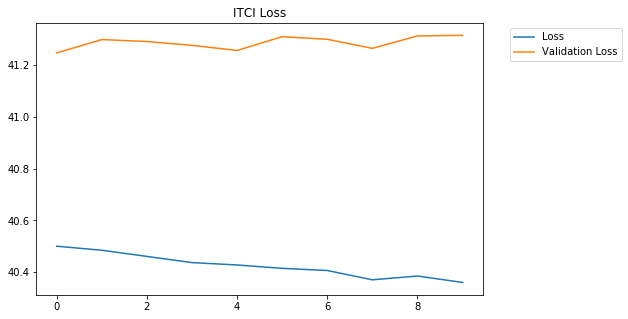

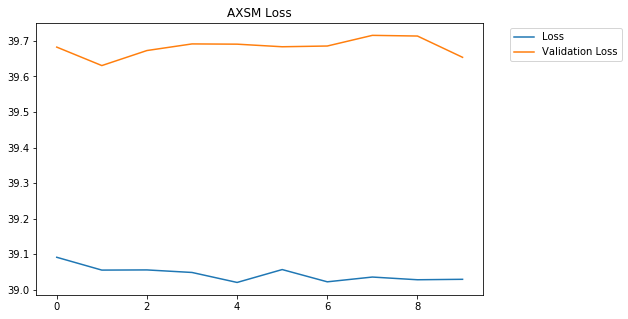

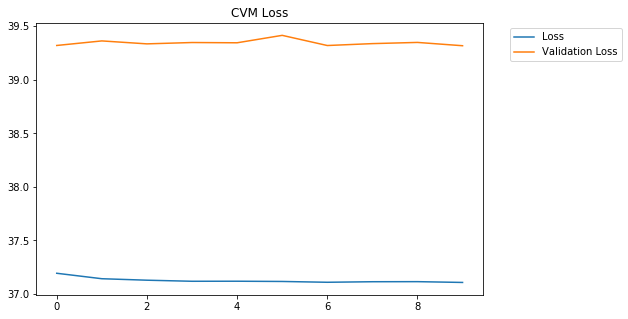

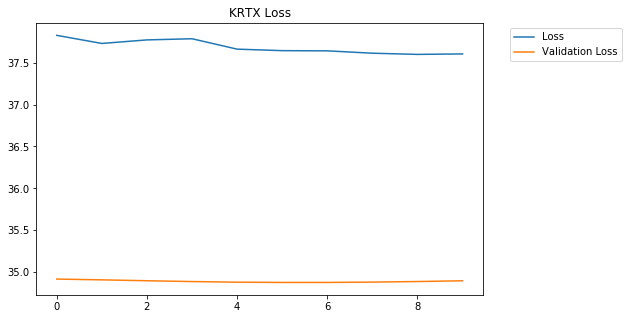

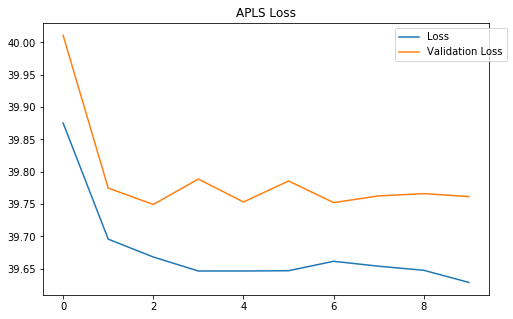

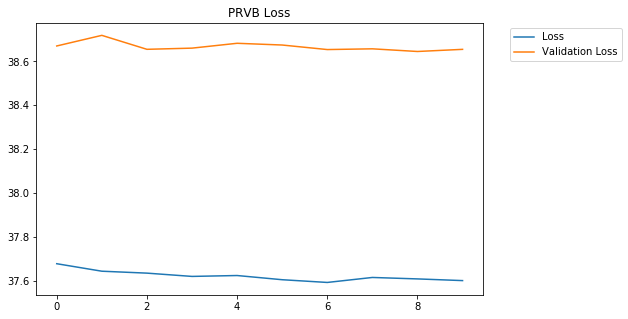

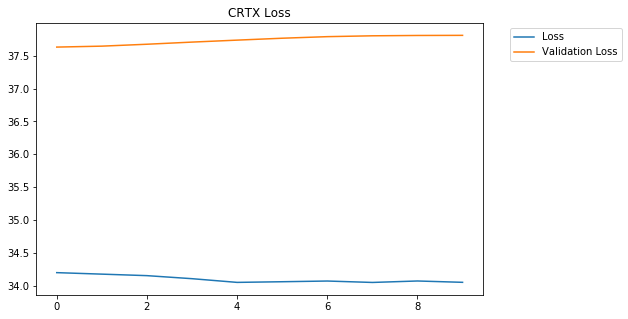

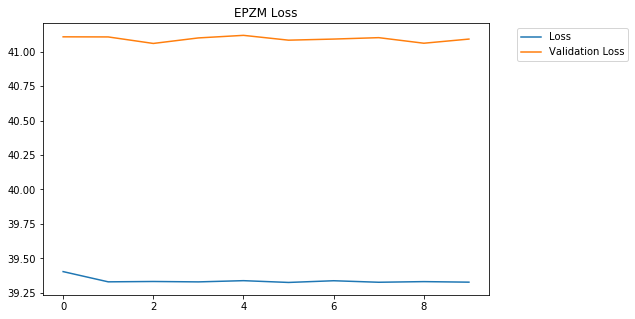

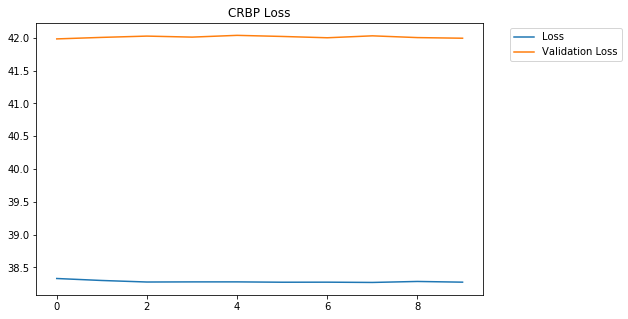

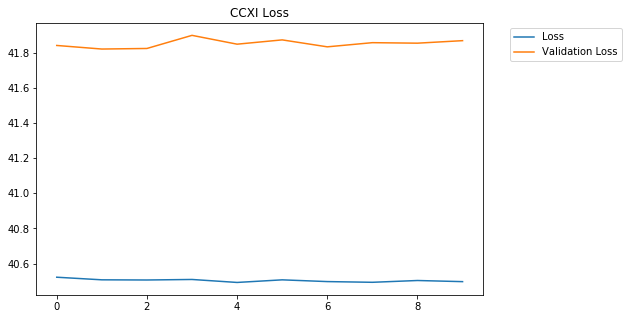

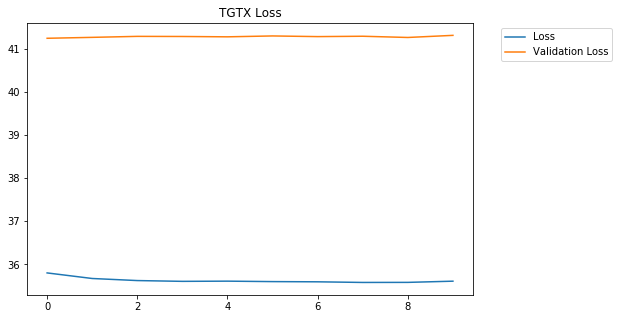

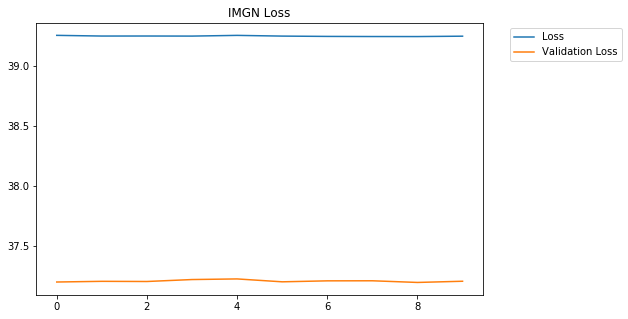

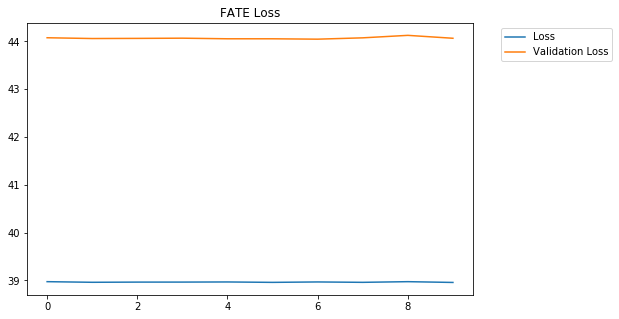

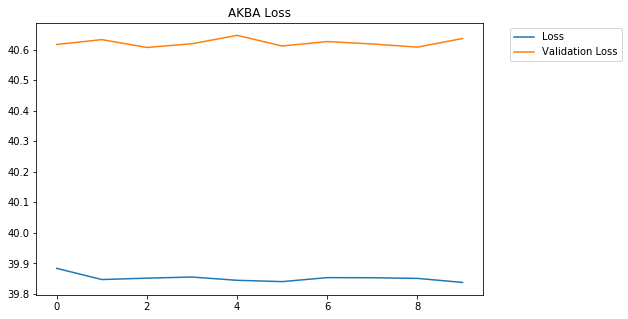

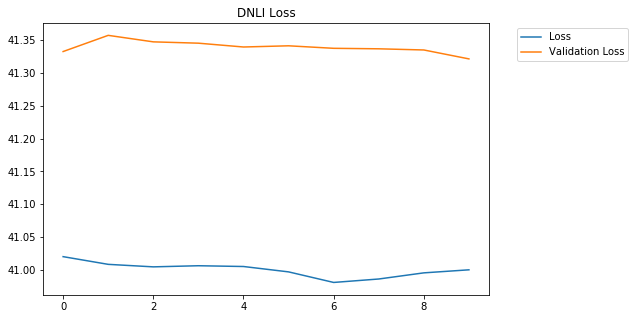

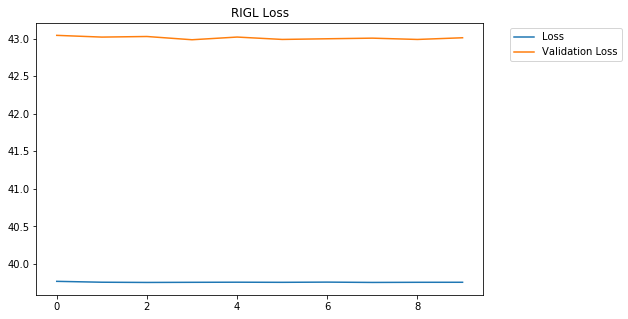

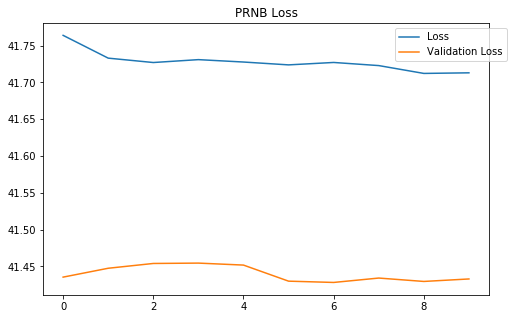

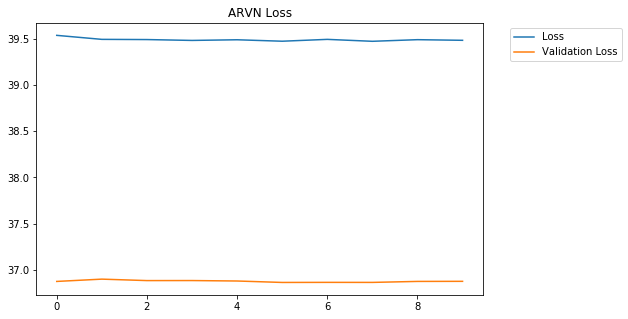

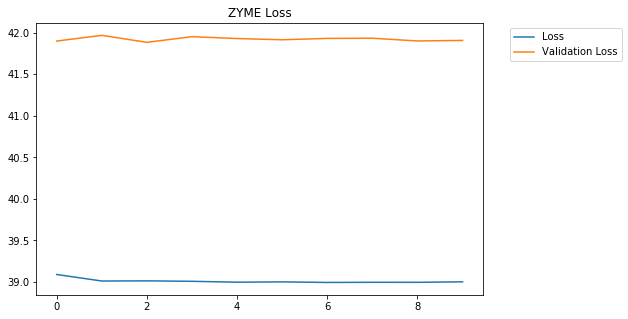

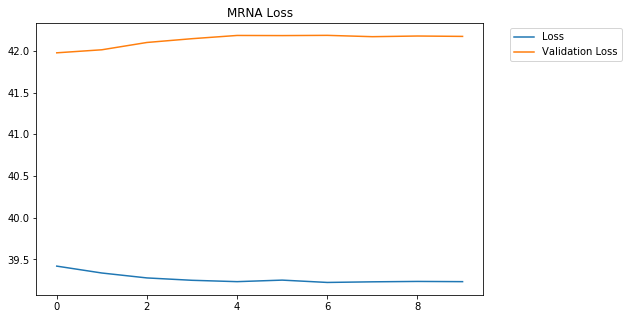

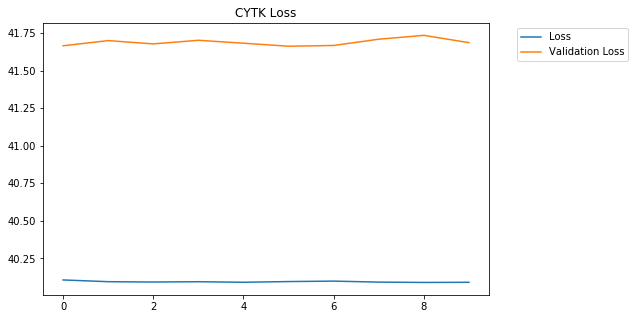

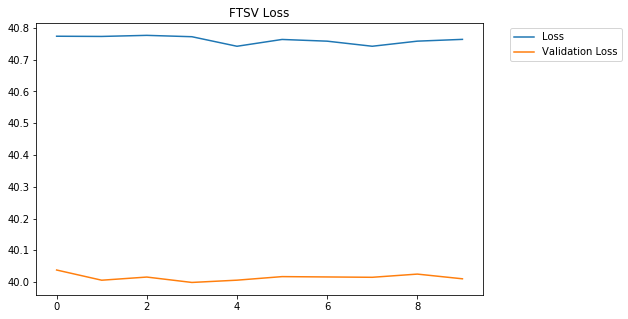

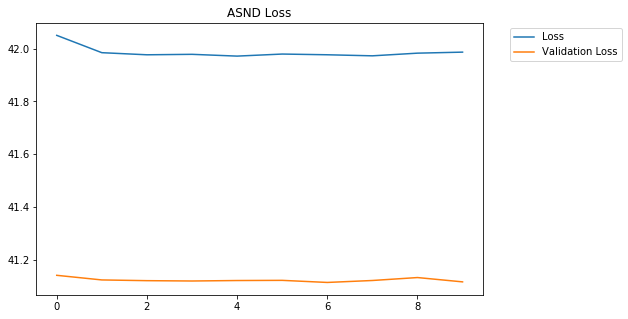

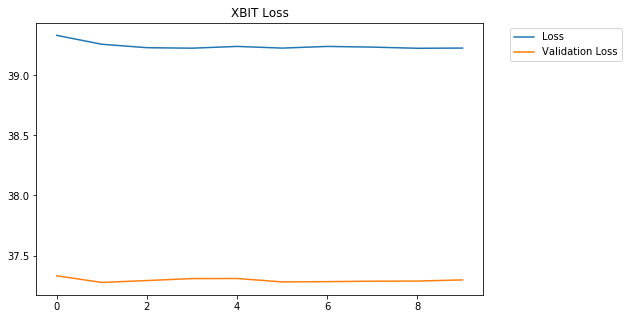

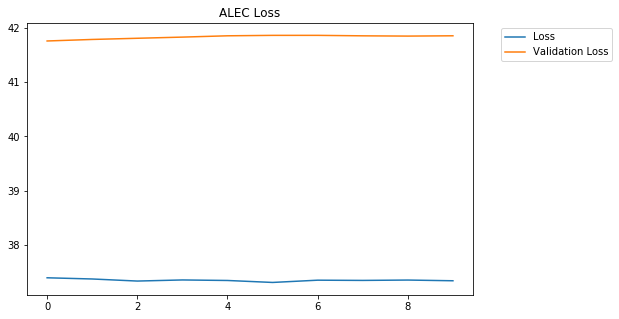

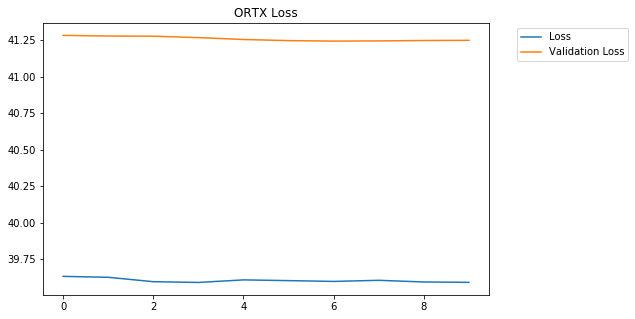

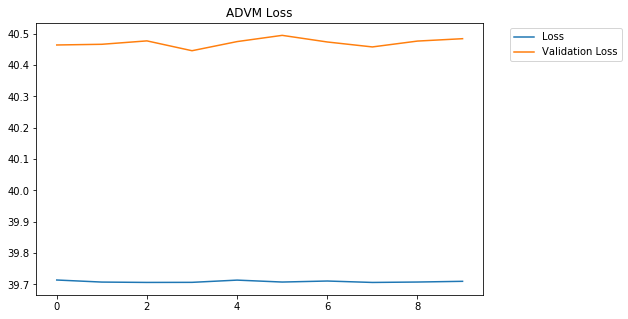

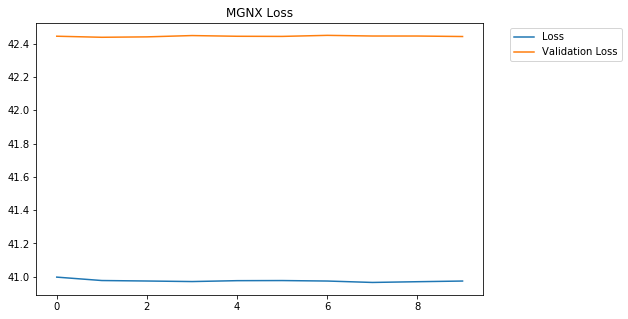

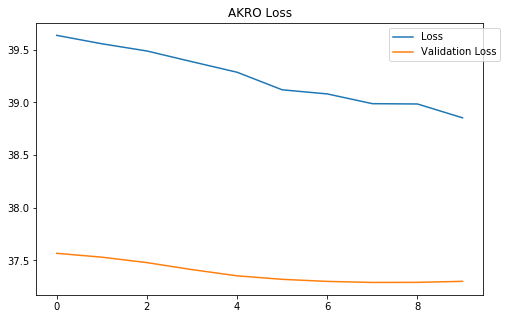

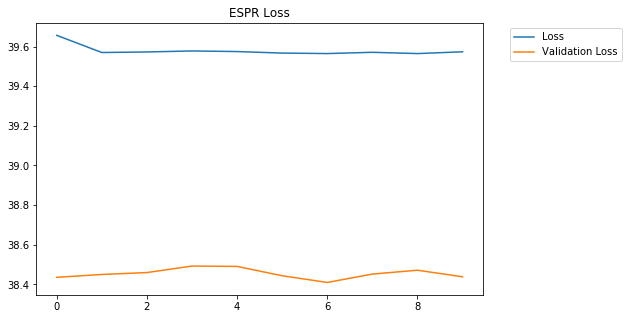

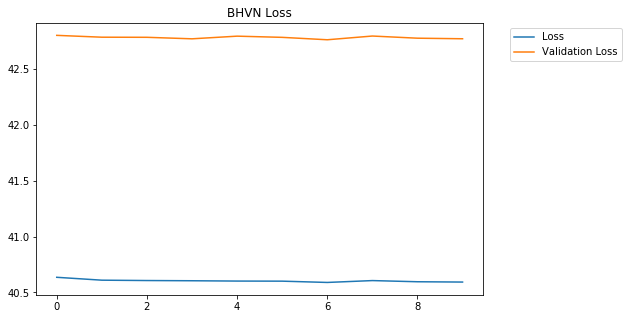

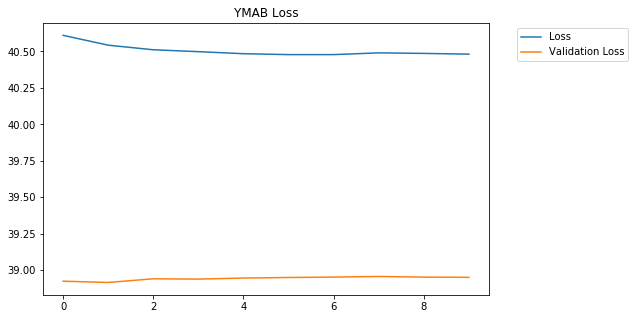

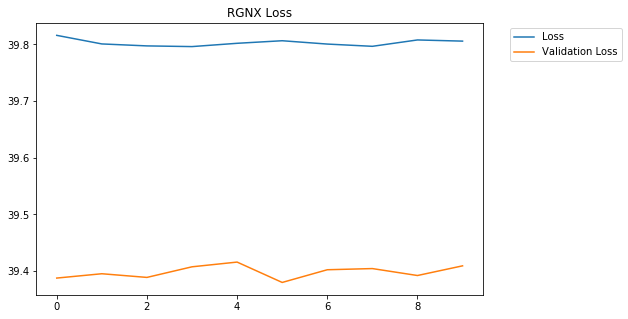

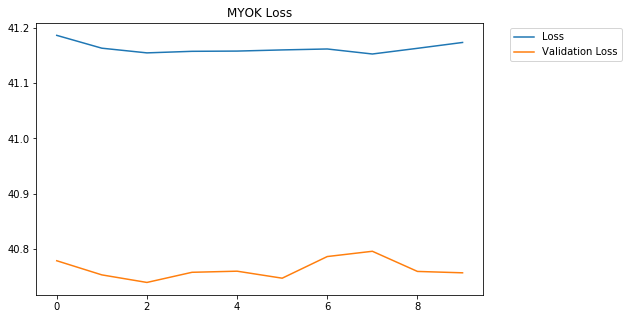

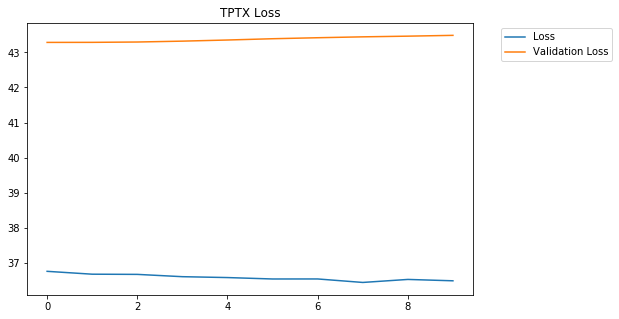

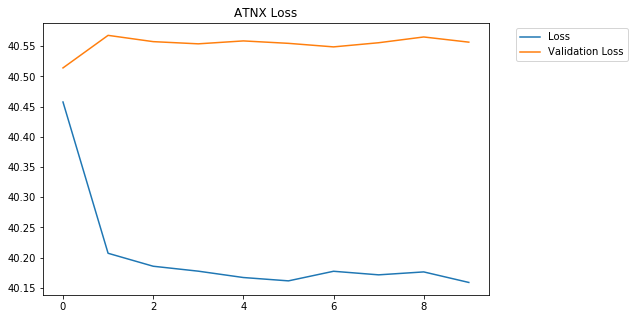

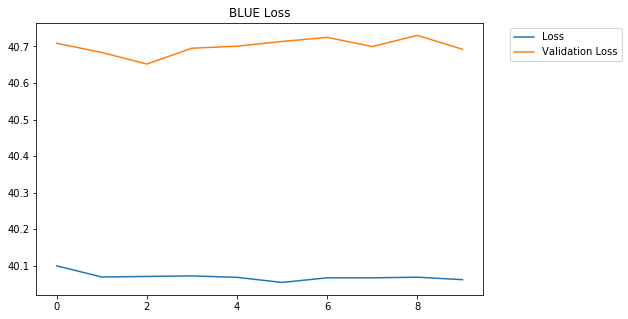

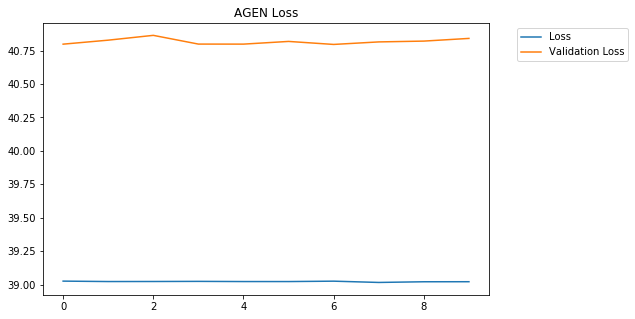

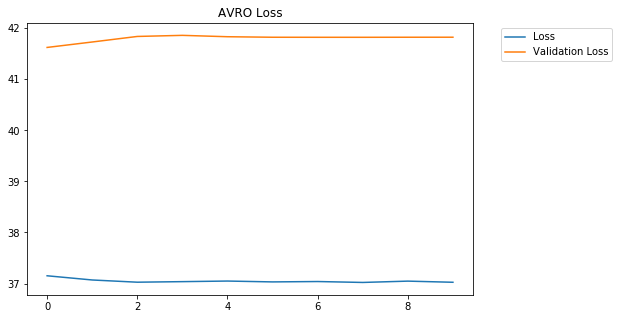

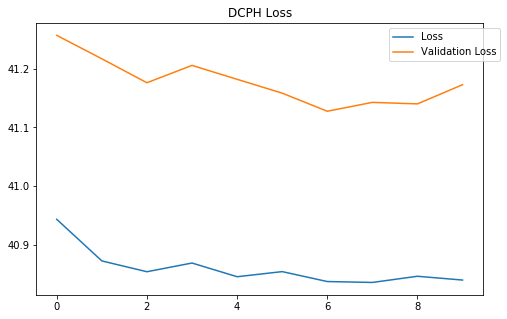

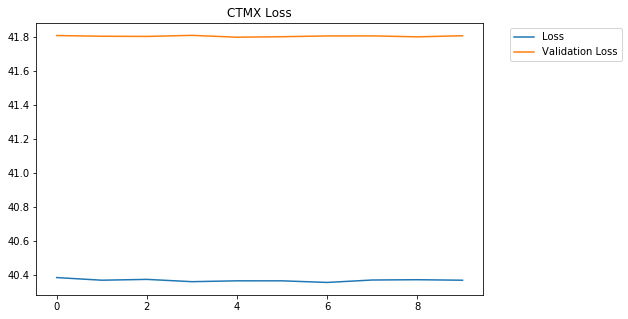

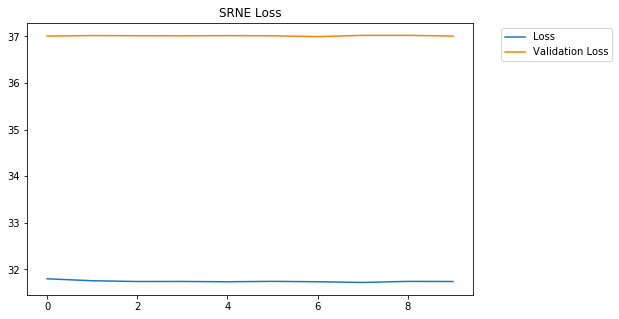

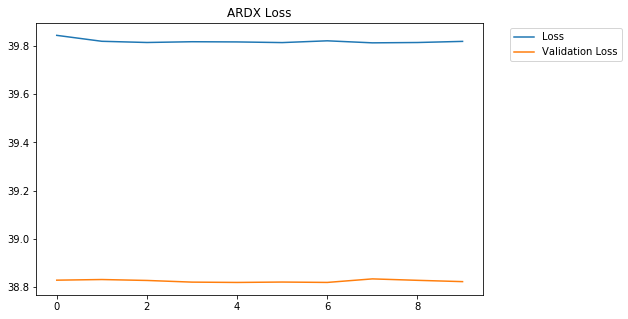

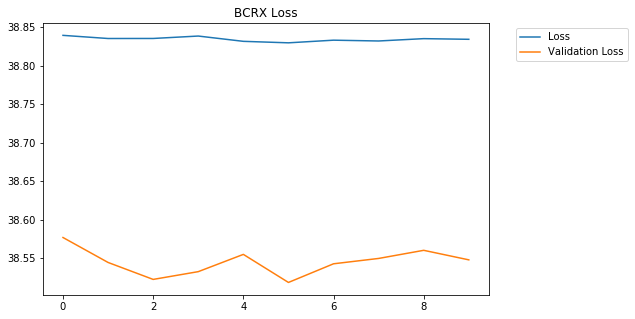

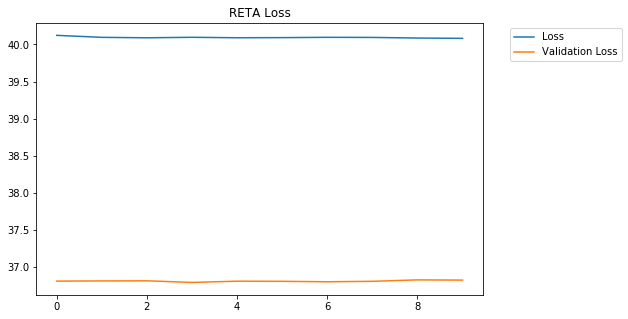

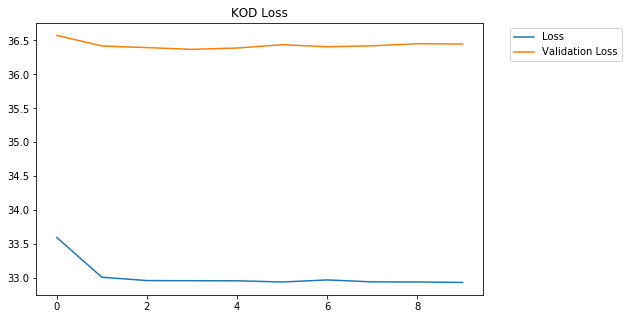

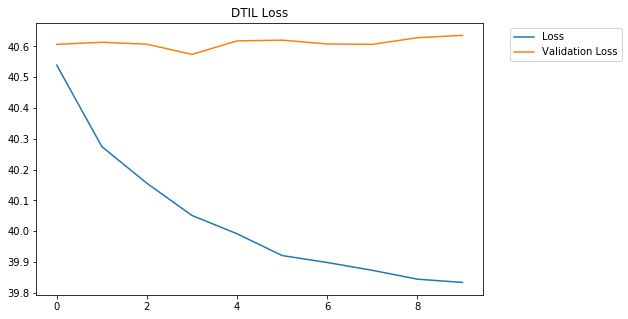

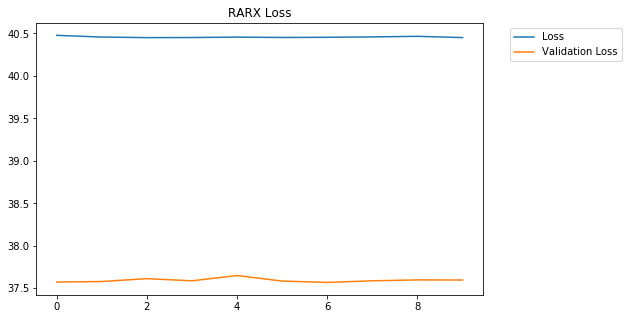

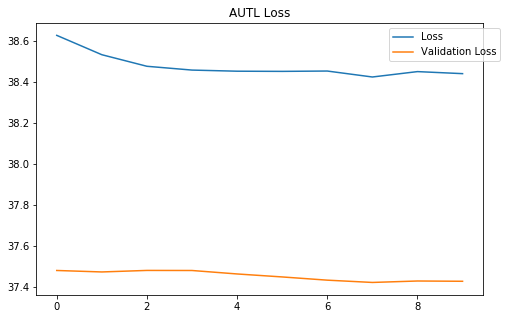

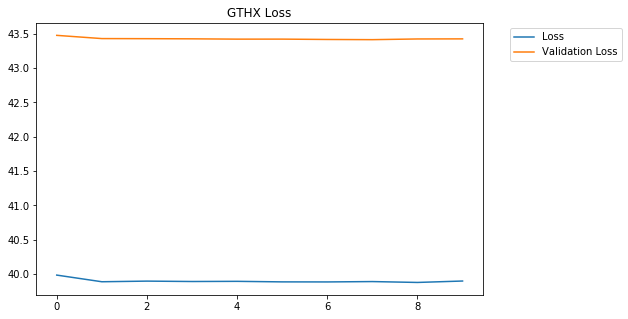

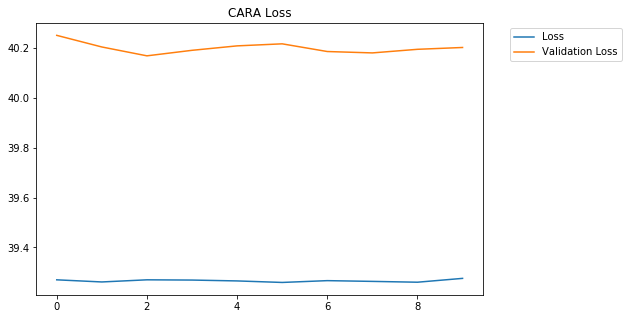

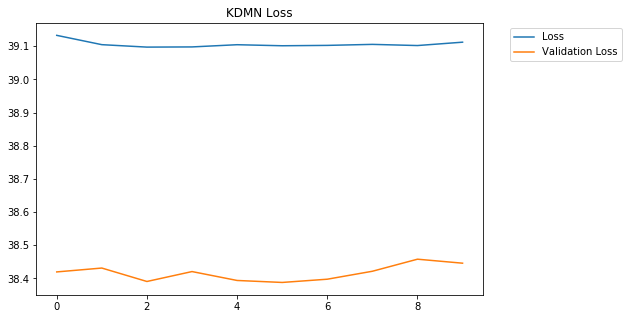

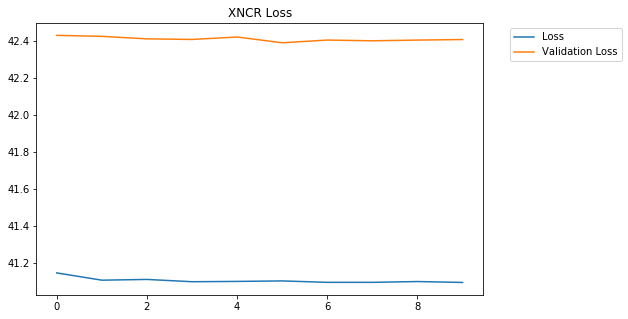

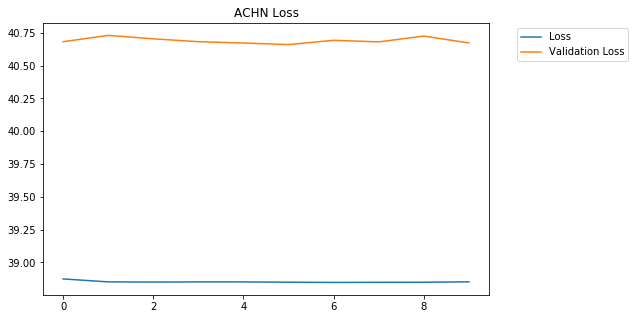

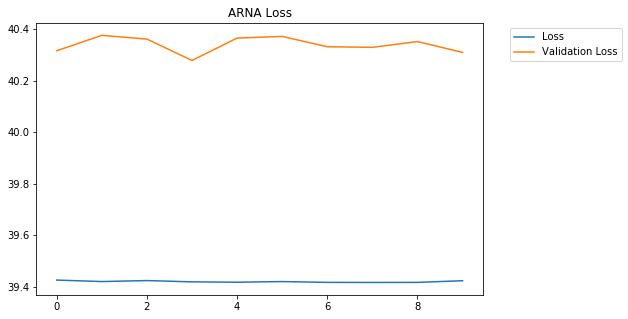

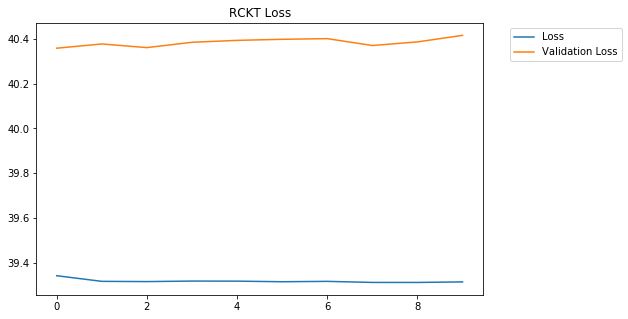

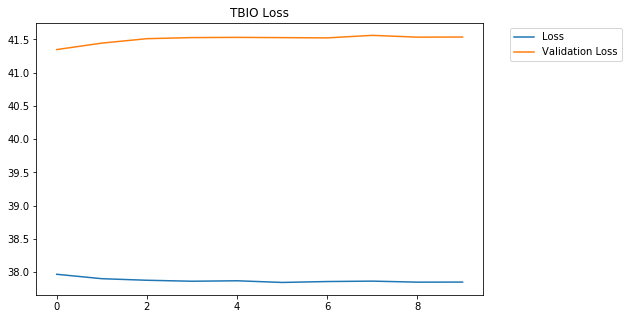

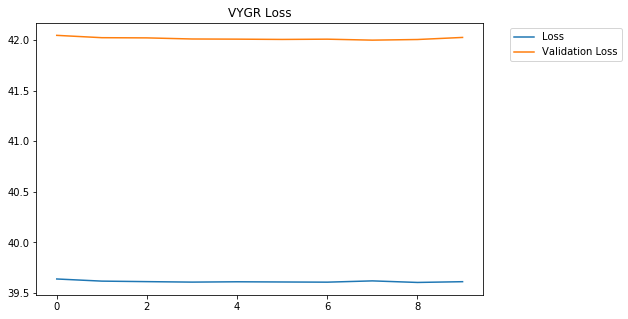

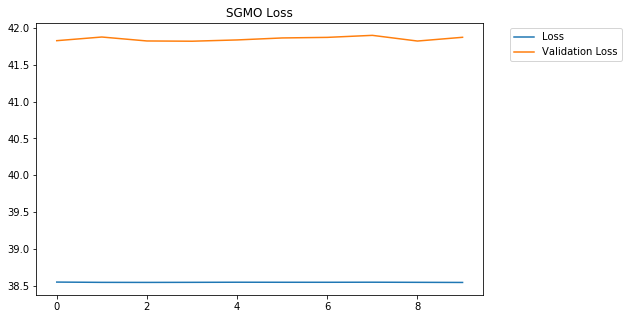

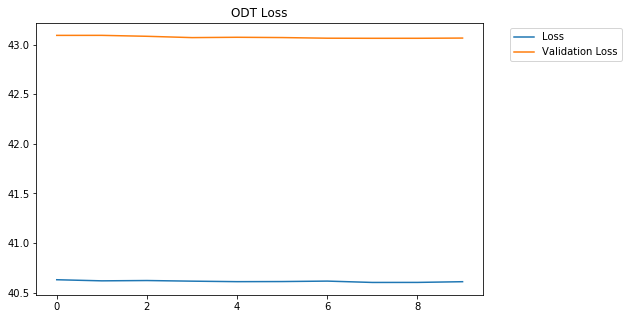

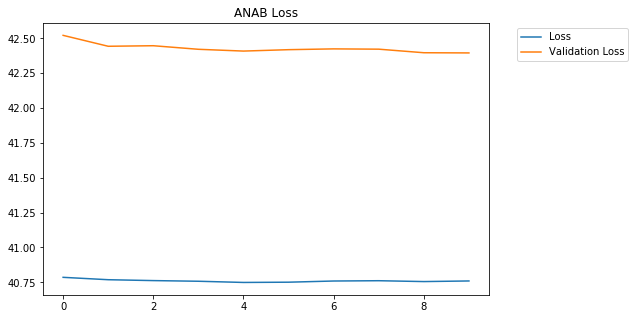

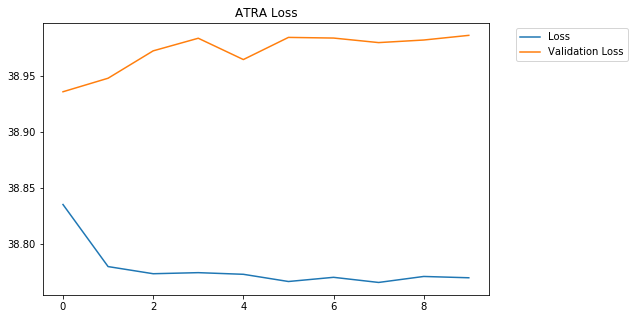

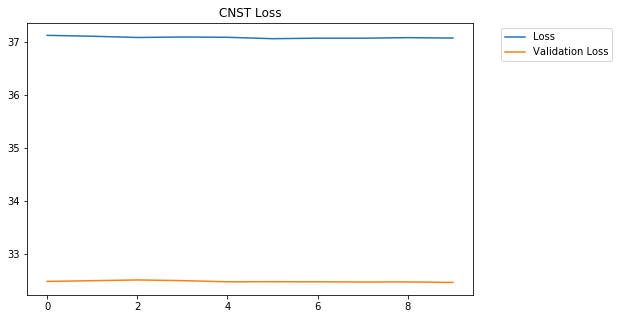

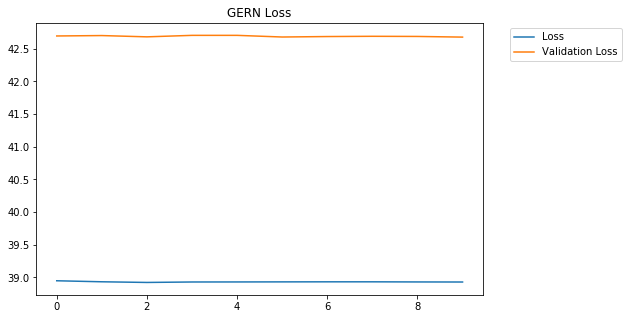

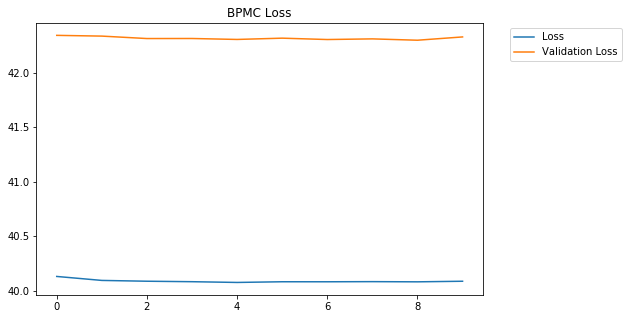

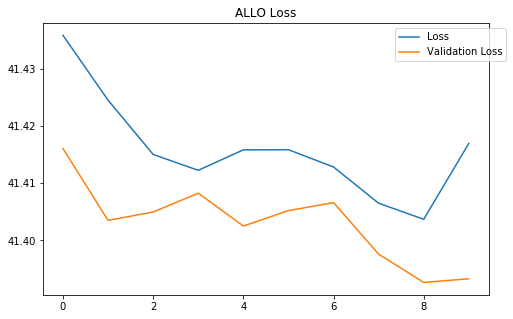

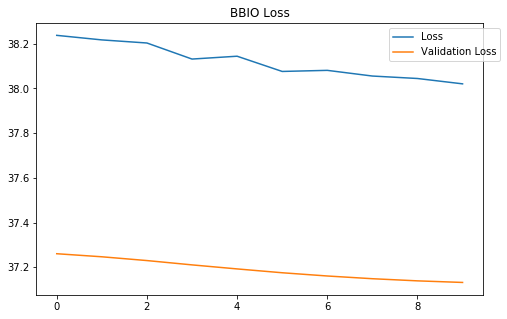

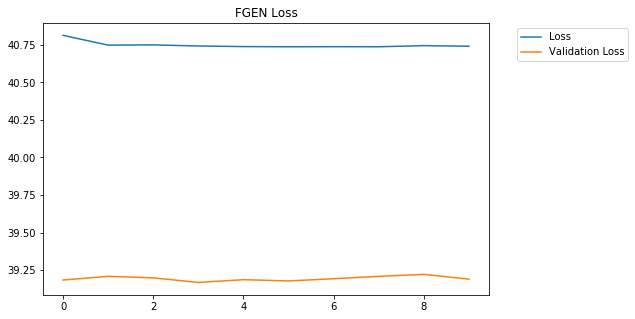

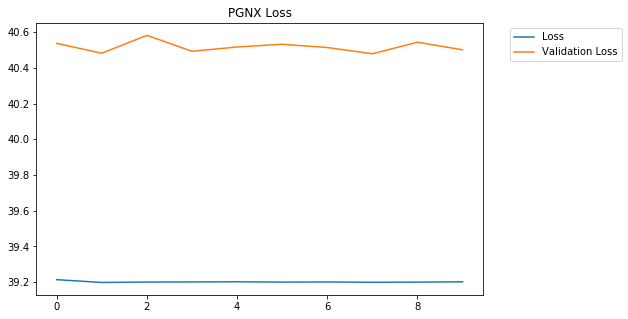

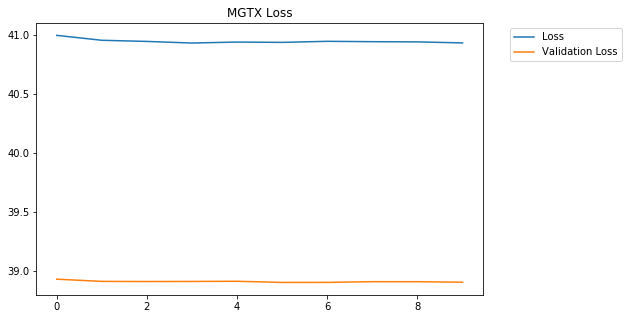

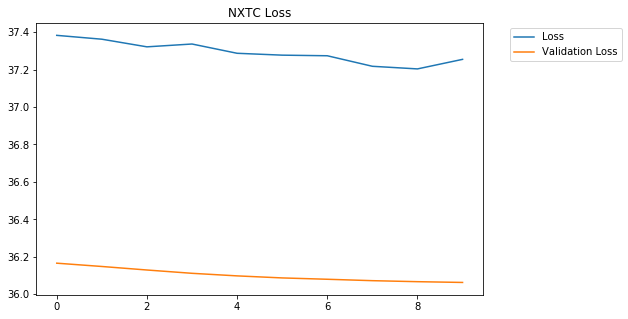

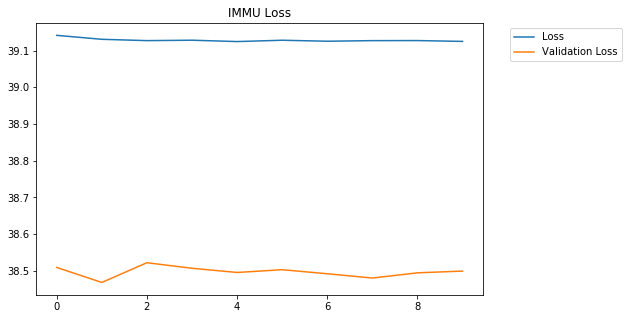

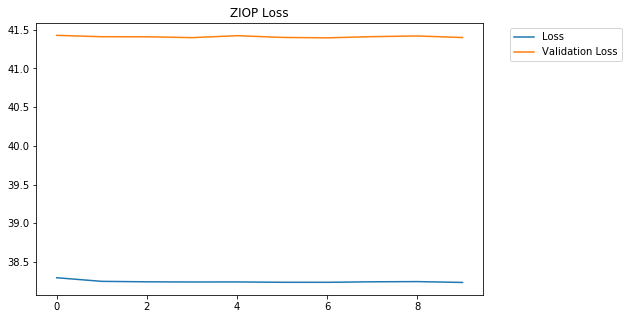

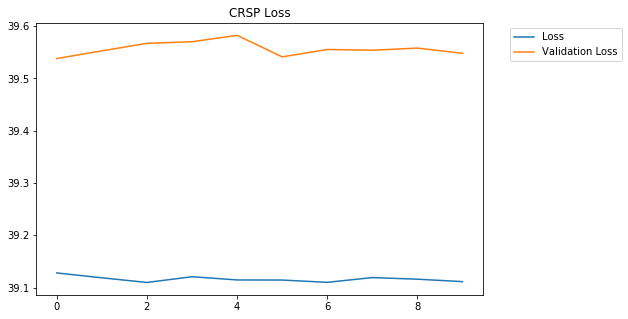

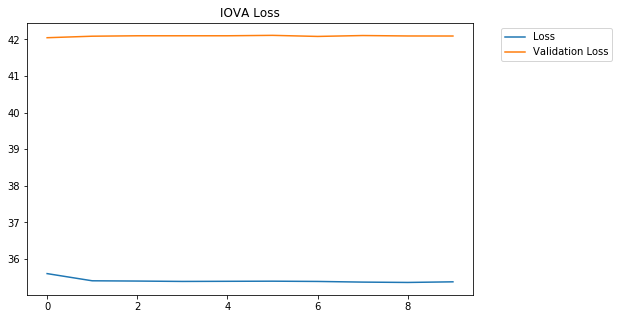

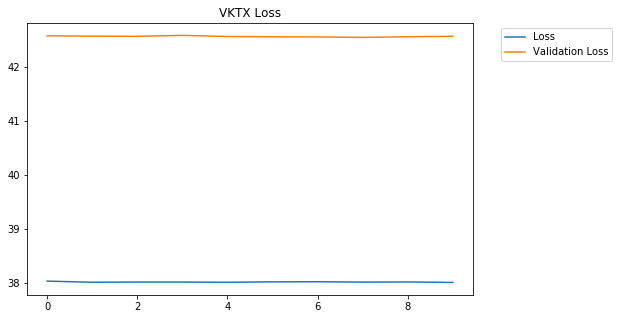

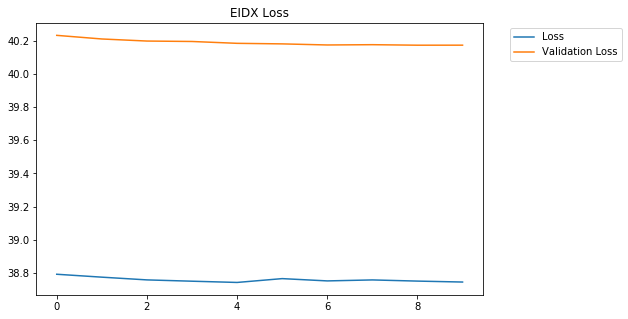

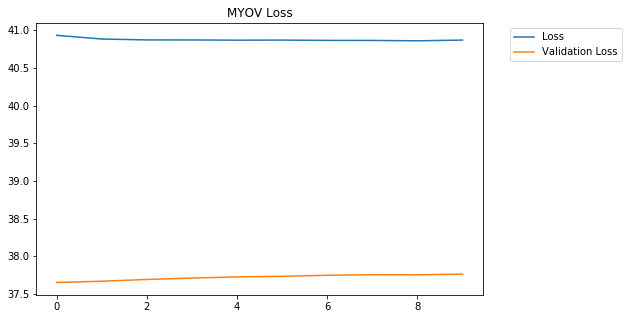

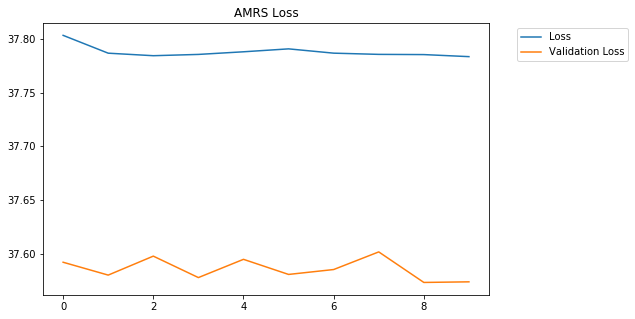

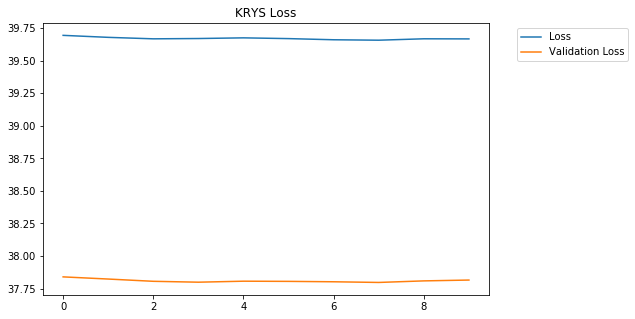

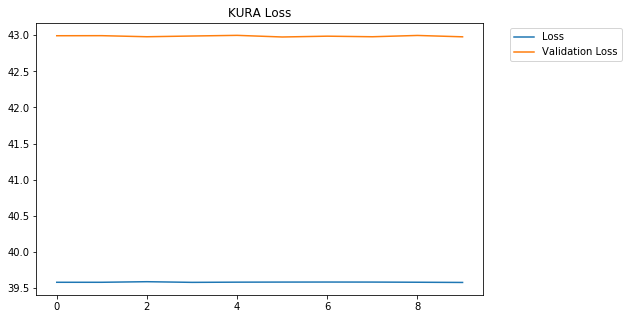

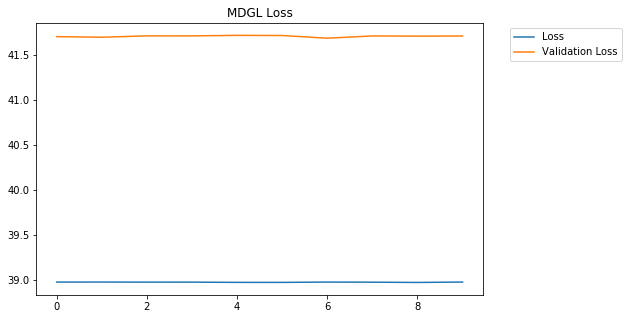

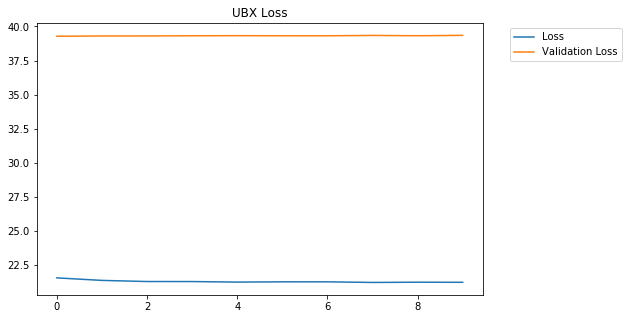

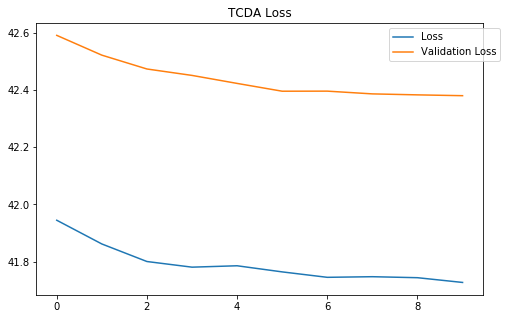

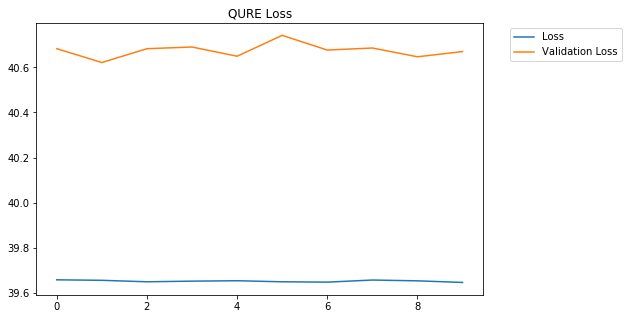

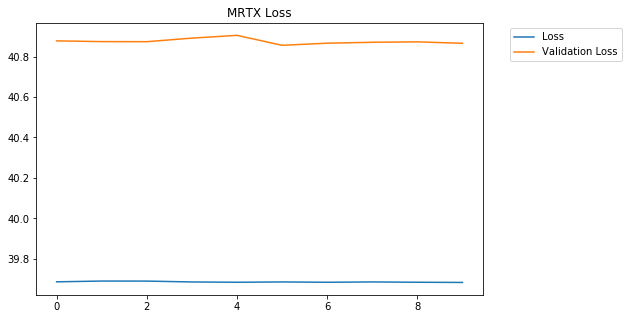

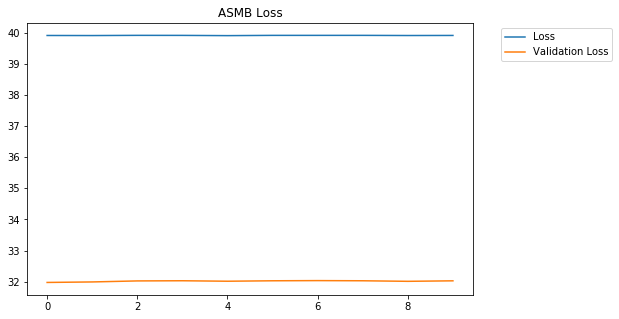

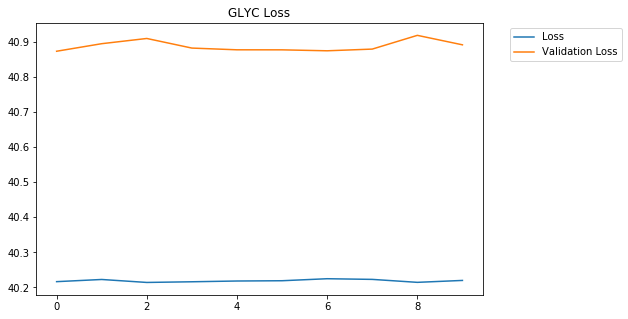

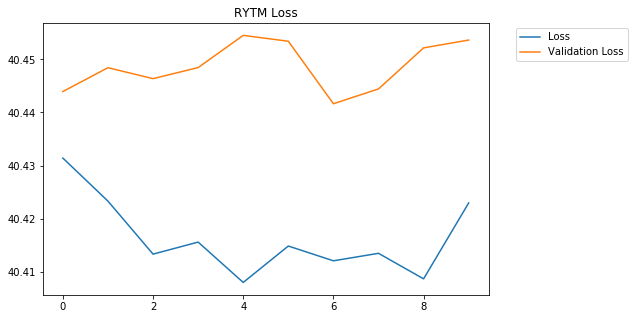

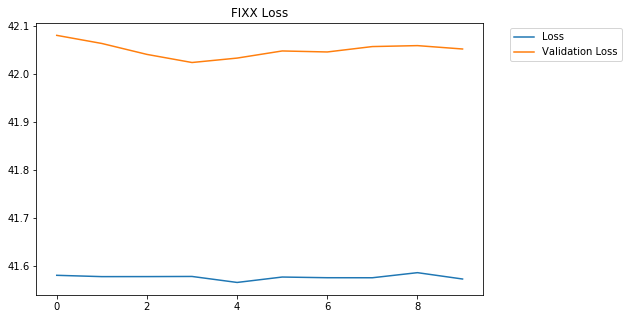

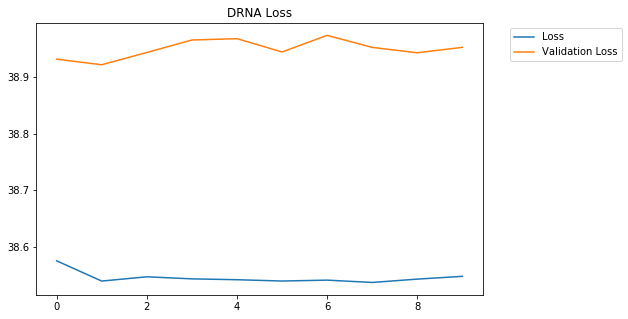

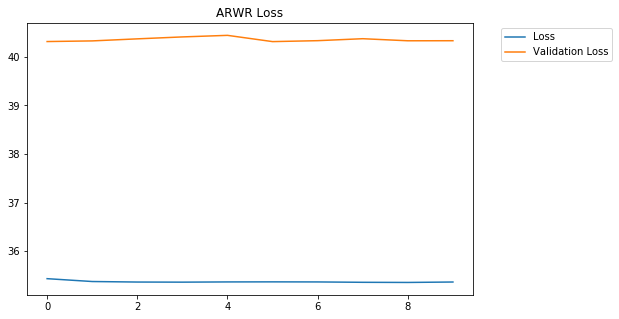

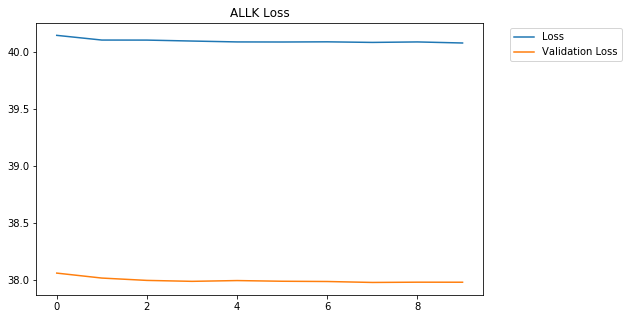

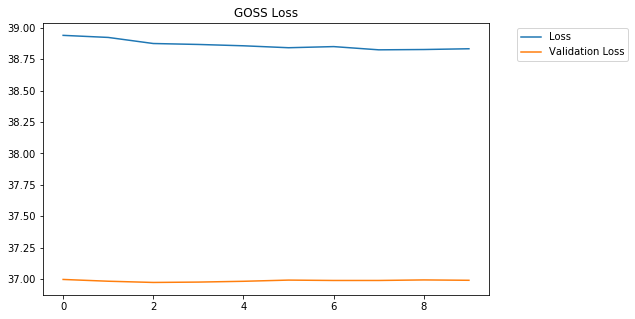

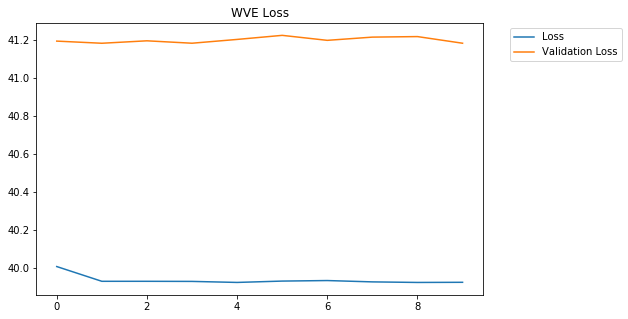

In [39]:
for stock in stocks:

  (feature_train, label_train, feature_test, label_test) = (processed_data[stock]['data_1'],processed_data[stock]['target_1'], 
                                                            processed_data[stock]['data_test'], processed_data[stock]['target_test']) 
  new_model.fit(feature_train, label_train, batch_size=25, epochs=10, validation_data = (feature_test, label_test), verbose=0)
  dict_ = new_model.history.history
  plt.figure(figsize=(8,5))
  plt.title(f"{stock} Loss")
  plt.plot(dict_['loss'], label = 'Loss')
  plt.plot(dict_['val_loss'], label= 'Validation Loss')
  plt.legend(bbox_to_anchor=(1.05, 1))
  plt.show()

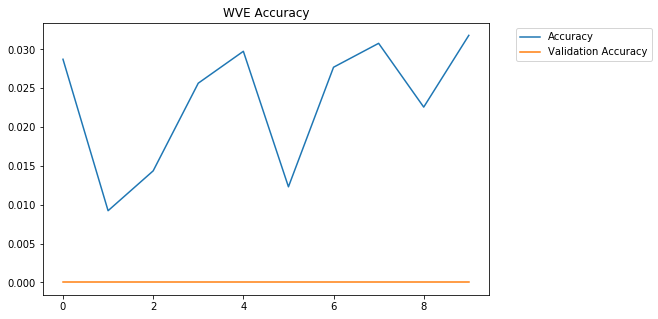

In [44]:
plt.figure(figsize=(8,5))
plt.title(f"{stock} Accuracy")
plt.plot(dict_['acc'], label = 'Accuracy')
plt.plot(dict_['val_acc'], label= 'Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

Train on 4900 samples, validate on 50 samples
Epoch 1/250
4900/4900 [==============================] - 2s 397us/step - loss: 38.5487 - acc: 0.0376 - val_loss: 41.8526 - val_acc: 0.1000
Epoch 2/250
4900/4900 [==============================] - 2s 360us/step - loss: 38.5422 - acc: 0.0312 - val_loss: 41.8525 - val_acc: 0.0000e+00
Epoch 3/250
4900/4900 [==============================] - 2s 366us/step - loss: 38.5429 - acc: 0.0400 - val_loss: 41.8391 - val_acc: 0.0400
Epoch 4/250
4900/4900 [==============================] - 2s 365us/step - loss: 38.5406 - acc: 0.0412 - val_loss: 41.8400 - val_acc: 0.1000
Epoch 5/250
4900/4900 [==============================] - 2s 357us/step - loss: 38.5410 - acc: 0.0320 - val_loss: 41.8666 - val_acc: 0.0400
Epoch 6/250
4900/4900 [==============================] - 2s 358us/step - loss: 38.5421 - acc: 0.0357 - val_loss: 41.7928 - val_acc: 0.0000e+00
Epoch 7/250
4900/4900 [==============================] - 2s 368us/step - loss: 38.5418 - acc: 0.0314 - val_loss:

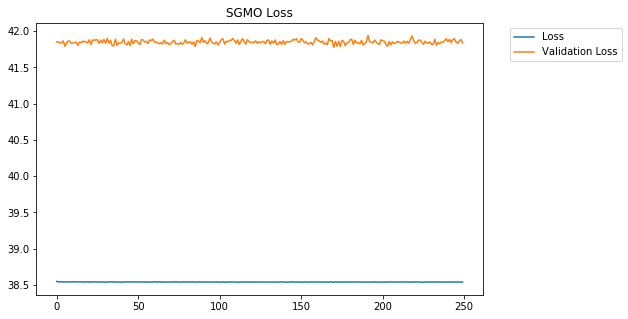

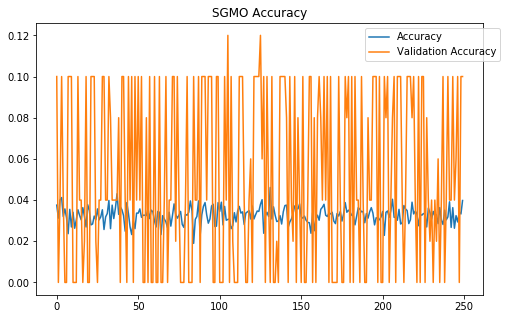

In [46]:
stock = 'SGMO'
(feature_train, label_train, feature_test, label_test) = (processed_data[stock]['data_1'],processed_data[stock]['target_1'], 
                                                            processed_data[stock]['data_test'], processed_data[stock]['target_test']) 
new_model.fit(feature_train, label_train, batch_size=25, epochs=250, validation_data = (feature_test, label_test))
dict_ = new_model.history.history
plt.figure(figsize=(8,5))
plt.title(f"{stock} Loss")
plt.plot(dict_['loss'], label = 'Loss')
plt.plot(dict_['val_loss'], label= 'Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

plt.figure(figsize=(8,5))
plt.title(f"{stock} Accuracy")
plt.plot(dict_['acc'], label = 'Accuracy')
plt.plot(dict_['val_acc'], label= 'Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [0]:
new_model.save('GRU_1_Day.h5')